In [1]:
!pip install transformers --quiet
!pip install opendatasets --quiet

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
!pip install scikit-learn --quiet

In [1]:
!pip install matplotlib --quiet

In [4]:
!pip install pandas --quiet

In [1]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  dharamendra13


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3.30M/3.30M [00:00<00:00, 1.80GB/s]

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plot
import pandas as pd
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(device)

cuda


In [3]:
data_df = pd.read_json('news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)
data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)
data_df.drop('article_link', inplace=True, axis=1)
print(data_df.shape)
data_df.head()

(26708, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(data_df["headline"]), np.array(data_df["is_sarcastic"]), test_size=0.3)

In [5]:
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test,test_size=0.5)

In [6]:
print("Training size:", X_train.shape[0], "Which is: ", round(X_train.shape[0]/data_df.shape[0],4) * 100, "%")
print("Validation size:", X_val.shape[0], "Which is: ", round(X_val.shape[0]/data_df.shape[0],4) * 100, "%")
print("Testing size:", X_test.shape[0], "Which is: ", round(X_test.shape[0]/data_df.shape[0],4) * 100, "%")


Training size: 18695 Which is:  70.0 %
Validation size: 4006 Which is:  15.0 %
Testing size: 4007 Which is:  15.0 %


In [7]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

In [8]:
class dataset(Dataset):
    def __init__(self, X,Y):
        self.X = [tokenizer(x,
                            max_length=100,
                            truncation= True,
                            padding='max_length',
                            return_tensors='pt').to(device)
                            for x in X
                 ]
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [9]:
training_data = dataset(X_train, Y_train)
validation_data = dataset(X_val, Y_val)
testing_data = dataset(X_test, Y_test)

In [10]:
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4

In [11]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
class MyModel(nn.Module):
    def __init__(self, bert):
        super(MyModel, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, **kwargs):  # Accept extra kwargs
        pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)[0][:, 0]
        output = self.dropout(pooled_output)
        output = self.linear1(output)
        output = self.linear2(output)
        output = self.sigmoid(output)
        return output


In [13]:
for param in bert_model.parameters():
    param.requires_grad = False
model = MyModel(bert_model).to(device)

In [14]:
model

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [15]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=2e-5)

In [16]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []
for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    for index, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs.to(device)
        labels.to(device)

        prediction = model(inputs["input_ids"].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)
        batch_loss = criterion(prediction, labels)
        total_loss_train += batch_loss.item()
        acc = (prediction.round() == labels).sum().item()
        total_acc_train += acc
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        for index, data in enumerate(val_dataloader):
            inputs, labels = data
            inputs.to(device)
            labels.to(device)
    
            prediction = model(inputs["input_ids"].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)
            batch_loss = criterion(prediction, labels)
            total_loss_val += batch_loss.item()
            acc = (prediction.round() == labels).sum().item()
            total_acc_val += acc
       
    total_loss_train_plot.append(round(total_loss_train/1000,4))
    total_loss_validation_plot.append(round(total_loss_val/1000,4))
    total_acc_train_plot.append(round((total_acc_train/training_data.__len__())* 100,4))
    total_acc_validation_plot.append(round((total_acc_val/validation_data.__len__())* 100,4))

    print(f"""
    Epoch No. {epoch+1} Train Loss: {round(total_loss_train/1000,4)} Train Accuracy: {round((total_acc_train/training_data.__len__())* 100,4)}
                        Validation Loss: {round(total_loss_val/1000,4)} Validation Accuracy: {round((total_acc_val/validation_data.__len__())* 100,4)}
    """
         )


    Epoch No. 1 Train Loss: 0.3248 Train Accuracy: 73.3084
                        Validation Loss: 0.0614 Validation Accuracy: 78.8318
    

    Epoch No. 2 Train Loss: 0.2701 Train Accuracy: 80.0909
                        Validation Loss: 0.055 Validation Accuracy: 81.3779
    

    Epoch No. 3 Train Loss: 0.2505 Train Accuracy: 81.471
                        Validation Loss: 0.053 Validation Accuracy: 81.1283
    

    Epoch No. 4 Train Loss: 0.2387 Train Accuracy: 82.7013
                        Validation Loss: 0.0506 Validation Accuracy: 82.9755
    

    Epoch No. 5 Train Loss: 0.2303 Train Accuracy: 83.295
                        Validation Loss: 0.0501 Validation Accuracy: 83.1752
    

    Epoch No. 6 Train Loss: 0.2269 Train Accuracy: 83.3966
                        Validation Loss: 0.049 Validation Accuracy: 83.8243
    

    Epoch No. 7 Train Loss: 0.2221 Train Accuracy: 83.4073
                        Validation Loss: 0.0479 Validation Accuracy: 83.3999
    

    Epoch 

In [19]:

with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, data in enumerate(test_dataloader):
    input, label = data
    input.to(device)
    label.to(device)

    prediction = model(input['input_ids'].squeeze(1),
                    input['attention_mask'].squeeze(1)).squeeze(1)

    batch_loss_test = criterion(prediction.squeeze(), label.float())
    total_loss_test += batch_loss_test.item()
    acc = (torch.round(prediction).float() == label.float()).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 83.53%


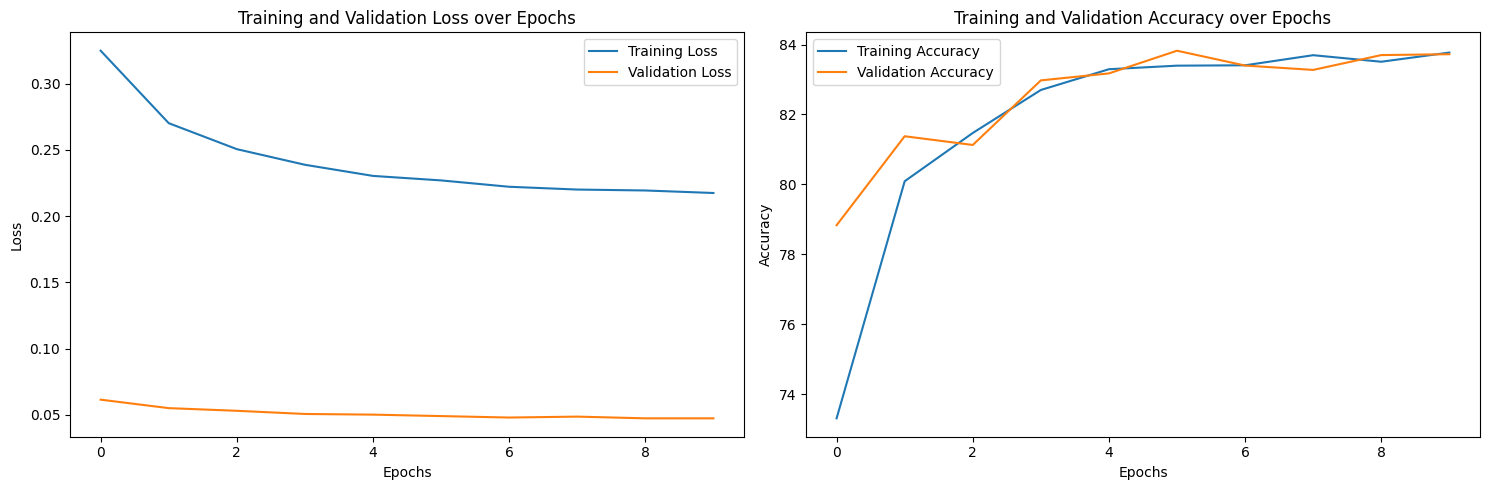

In [22]:

fig, axs = plot.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plot.tight_layout()

plot.show()
     